In [53]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from mlxtend.classifier import StackingClassifier
import seaborn as sns
import math
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, log_loss, make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV,cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
import pydotplus
from IPython.display import Image
import io
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier, XGBRegressor
import pickle
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
import numpy as np, pandas as pd
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.datasets import load_iris
import sklearn.cluster as cluster
import time
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from pandas.plotting import scatter_matrix
import os

# Loading Dataset and Column Types

In [54]:
fund = pd.read_csv('startup_funding.csv')

In [55]:
fund.head()
fund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 11 columns):
SNo                 2372 non-null int64
Date                2372 non-null object
StartupName         2372 non-null object
IndustryVertical    2201 non-null object
SubVertical         1436 non-null object
CityLocation        2193 non-null object
InvestorsName       2364 non-null object
InvestmentType      2371 non-null object
AmountInUSD         1525 non-null object
Remarks             419 non-null object
Final Remarks       213 non-null object
dtypes: int64(1), object(10)
memory usage: 203.9+ KB


# Missing values

In [56]:
#Rows
total = fund.isnull().sum(axis=1).sort_values(ascending=False)
percent = (fund.isnull().sum(axis=1))/(fund.isnull().count(axis=1).sort_values(ascending=False))
missing_data = pd.concat([total,percent], axis=1, keys=['Total_missing_values_per_row', 'Percent'])
missing_data.head()

,Total_missing_values_per_row,Percent
0,2,0.181818
1,3,0.272727
2,3,0.272727
3,2,0.181818
4,2,0.181818


In [59]:
#missing data observing in columns
total = fund.isnull().sum(axis=0).sort_values(ascending=False)
percent = ((fund.isnull().sum(axis=0)/fund.isnull().count(axis=0))*100).sort_values(ascending=False)

# count the number of null values in the column and their perecentage of the total data
missing_data_columns = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_columns.iloc[1:,:]

,Total,Percent
Remarks,1953,82.335582
SubVertical,936,39.460371
AmountInUSD,847,35.708263
CityLocation,179,7.546374
IndustryVertical,171,7.209106
InvestorsName,8,0.337268
InvestmentType,1,0.042159
StartupName,0,0.000000
Date,0,0.000000
SNo,0,0.000000


# Fixing Data

In [60]:
fund['StartupName'] = fund['StartupName'].replace({"Flipkart.com":"Flipkart"})
fund['IndustryVertical']=fund['IndustryVertical'].replace({"ECommerce":"eCommerce"})
fund['IndustryVertical']=fund['IndustryVertical'].replace({"ecommerce":"eCommerce"})
fund['IndustryVertical']=fund['IndustryVertical'].replace({"Ecommerce":"eCommerce"})
fund['InvestmentType']=fund['InvestmentType'].replace({"Crowd funding":"Crowd Funding"})
fund['InvestmentType']=fund['InvestmentType'].replace({"SeedFunding":"Seed Funding"})
fund['InvestmentType']=fund['InvestmentType'].replace({"PrivateEquity":"Private Equity"})
fund['StartupName']=fund['StartupName'].replace({"practo":"Practo"})
fund['StartupName']=fund['StartupName'].replace({"couponmachine.in":"Couponmachine"})
fund['StartupName']=fund['StartupName'].replace({"Olacabs":"Ola Cabs"})
fund['StartupName']=fund['StartupName'].replace({"Ola":"Ola Cabs"})
fund['InvestorsName']=fund['InvestorsName'].replace({"Undisclosed investors":"Undisclosed Investors"})
fund['InvestorsName']=fund['InvestorsName'].replace({"Undisclosed Investor":"Undisclosed Investors"})
fund['InvestorsName']=fund['InvestorsName'].replace({"Undisclosed":"Undisclosed Investors"})
fund['InvestorsName']=fund['InvestorsName'].replace({"undisclosed investors":"Undisclosed Investors"})
fund['InvestorsName']=fund['InvestorsName'].replace({"Undisclosed investor":"Undisclosed Investors"})
fund['InvestorsName']=fund['InvestorsName'].replace({" Sequoia Capital":"Sequoia Capital"})
fund['InvestorsName']=fund['InvestorsName'].replace({" Accel Partners":"Accel Partners"})
fund['InvestorsName']=fund['InvestorsName'].replace({" Blume Ventures":"Blume Ventures"})
fund['InvestorsName']=fund['InvestorsName'].replace({" SAIF Partners":"SAIF Partners"})
fund['InvestorsName']=fund['InvestorsName'].replace({" Kalaari Capital":"Kalaari Capital"})

# Flipkart and Paytm were funded multiple times

In [61]:
fund[fund['StartupName'] == "Paytm"]

,SNo,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Remarks,Final Remarks
158,158,18/05/17,Paytm,eCommerce,Mobile Wallet & ECommerce platform,Bangalore,SoftBank Group,Private Equity,"1,40,00,00,000",NaN,NaN
821,821,30/08/16,Paytm,eCommerce,Mobile Wallet & ECommerce platform,Bangalore,MediaTek Inc.,Private Equity,"6,00,00,000",NaN,NaN
1787,1787,29/09/15,Paytm,E-Commerce & M-Commerce platform,NaN,New Delhi,"Alibaba Group, Ant Financial",Private Equity,"68,00,00,000",Late Stage (Alibaba @ 40% equity),Late Stage
2218,2218,13/03/15,Paytm,NaN,NaN,NaN,Ratan Tata,Private Equity,NaN,More details,NaN
2276,2276,05/02/15,Paytm,NaN,NaN,NaN,Ant Financial Services (Alipay),Private Equity,NaN,Strategic Investment (25% stake),Strategic Funding


In [62]:
fund[fund['StartupName'] == "Flipkart"]

,SNo,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Remarks,Final Remarks
101,101,26/06/17,Flipkart,eCommerce,Online marketplace,Bangalore,Naspers,Private Equity,"7,10,00,000",NaN,NaN
294,294,21/03/17,Flipkart,eCommerce,ECommerce Marketplace,Bangalore,"Microsoft, eBay, Tencent Holdings",Private Equity,"1,40,00,00,000",NaN,NaN
360,360,20/02/17,Flipkart,eCommerce,Online Marketplace,Bangalore,"Bennett, Coleman and Co. Ltd (BCCL)",Private Equity,"3,87,00,000",NaN,NaN
1976,1976,28/07/15,Flipkart,Online Marketplace,NaN,Bangalore,Steadview Capital and existing investors,Private Equity,"70,00,00,000","Late Stage, 10th Round More here",Late Stage
2017,2017,04/06/15,Flipkart,eCommerce platform,NaN,Bangalore,Morgan Stanley,Private Equity,"5,00,00,000",Late Stage,Late Stage


# Convert Date to Date Time

In [63]:
fund['Date'] = pd.to_datetime(fund['Date'])

In [64]:
fund.head()

,SNo,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Remarks,Final Remarks
0,0,2017-01-08,TouchKin,Technology,Predictive Care Platform,Bangalore,Kae Capital,Private Equity,"13,00,000",NaN,NaN
1,1,2017-02-08,Ethinos,Technology,Digital Marketing Agency,Mumbai,Triton Investment Advisors,Private Equity,NaN,NaN,NaN
2,2,2017-02-08,Leverage Edu,Consumer Internet,Online platform for Higher Education Services,New Delhi,"Kashyap Deorah, Anand Sankeshwar, Deepak Jain,...",Seed Funding,NaN,NaN,NaN
3,3,2017-02-08,Zepo,Consumer Internet,DIY Ecommerce platform,Mumbai,"Kunal Shah, LetsVenture, Anupam Mittal, Hetal ...",Seed Funding,"5,00,000",NaN,NaN
4,4,2017-02-08,Click2Clinic,Consumer Internet,healthcare service aggregator,Hyderabad,"Narottam Thudi, Shireesh Palle",Seed Funding,"8,50,000",NaN,NaN


In [65]:
fund.info()
fund['AmountInUSD'] = fund['AmountInUSD'].str.replace(',','').astype(float)
fund.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 11 columns):
SNo                 2372 non-null int64
Date                2372 non-null datetime64[ns]
StartupName         2372 non-null object
IndustryVertical    2201 non-null object
SubVertical         1436 non-null object
CityLocation        2193 non-null object
InvestorsName       2364 non-null object
InvestmentType      2371 non-null object
AmountInUSD         1525 non-null object
Remarks             419 non-null object
Final Remarks       213 non-null object
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 203.9+ KB


,SNo,Date,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Remarks,Final Remarks
0,0,2017-01-08,TouchKin,Technology,Predictive Care Platform,Bangalore,Kae Capital,Private Equity,1300000.0,NaN,NaN
1,1,2017-02-08,Ethinos,Technology,Digital Marketing Agency,Mumbai,Triton Investment Advisors,Private Equity,NaN,NaN,NaN
2,2,2017-02-08,Leverage Edu,Consumer Internet,Online platform for Higher Education Services,New Delhi,"Kashyap Deorah, Anand Sankeshwar, Deepak Jain,...",Seed Funding,NaN,NaN,NaN
3,3,2017-02-08,Zepo,Consumer Internet,DIY Ecommerce platform,Mumbai,"Kunal Shah, LetsVenture, Anupam Mittal, Hetal ...",Seed Funding,500000.0,NaN,NaN
4,4,2017-02-08,Click2Clinic,Consumer Internet,healthcare service aggregator,Hyderabad,"Narottam Thudi, Shireesh Palle",Seed Funding,850000.0,NaN,NaN


In [66]:
fund_withAmts = fund.dropna(subset=['AmountInUSD', 'CityLocation'])
fund_withAmts.head()
fund_withAmts.shape

(1390, 11)

In [67]:
fund_withAmts['CityLocation'].value_counts()

Bangalore                405
Mumbai                   300
New Delhi                212
Gurgaon                  165
Pune                      54
Hyderabad                 53
Chennai                   47
Noida                     45
Ahmedabad                 25
Jaipur                    10
Kolkata                    8
Vadodara                   5
Chandigarh                 5
Pune / US                  4
Goa                        4
Singapore                  3
Indore                     3
Gwalior                    2
Bhopal                     2
Kanpur                     2
Bangalore/ Bangkok         2
Coimbatore                 2
Bangalore / SFO            2
New Delhi / US             2
Bangalore / San Mateo      1
Pune / Dubai               1
Bangalore / USA            1
SFO / Bangalore            1
Missourie                  1
Udupi                      1
Delhi                      1
USA/India                  1
Bangalore / Palo Alto      1
Gurgaon / SFO              1
Boston        

Consumer Internet                459
Technology                       189
eCommerce                        149
Logistics                         16
Education                         15
Healthcare                        14
Food & Beverage                   12
Finance                            7
Online Food Delivery               5
Others                             4
Big Data & Analytics platform      3
Online Education Platform          3
Hyperlocal Handyman Services       3
Fashion Discovery platform         2
Used Car Marketplace               2
Logistics Tech                     2
Digital / Mobile Wallet            2
Health-Tech platform               2
Logistics Tech Platform            2
Online budget hotel chain          2
Name: IndustryVertical, dtype: int64


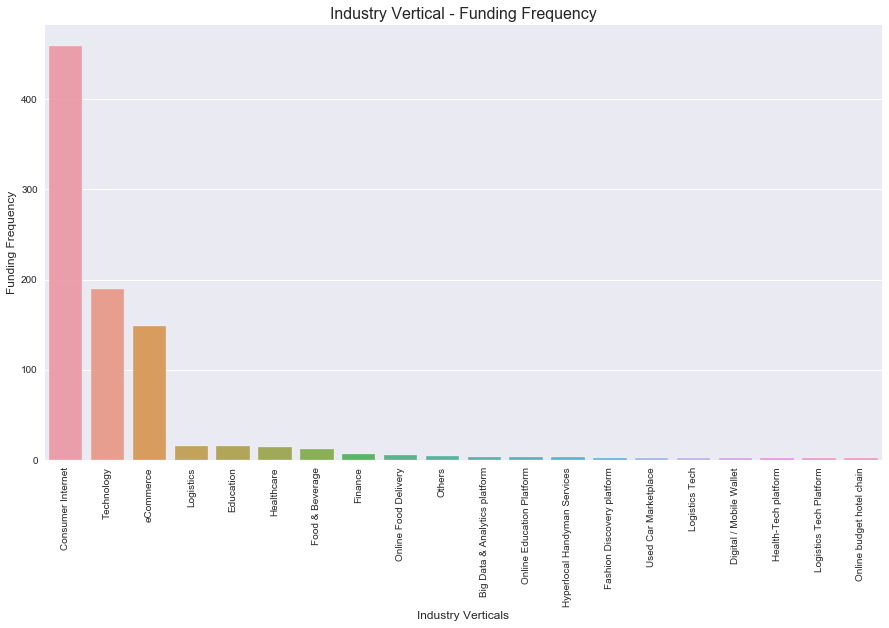

In [68]:
IndustryVertical = fund_withAmts['IndustryVertical'].value_counts().head(20)
print(IndustryVertical)
plt.figure(figsize=(15,8))
sns.barplot(IndustryVertical.index, IndustryVertical.values, alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Industry Verticals', fontsize=12)
plt.ylabel('Funding Frequency', fontsize=12)
plt.title("Industry Vertical - Funding Frequency", fontsize=16)
plt.show()

Consumer Internet (19.4%), Technology (8%) and eCommerce Industries (6.3%) were most favoured for funding in the years - 2015, 2016 & 2017


Seed Funding      1301
Private Equity    1067
Crowd Funding        2
Debt Funding         1
Name: InvestmentType, dtype: int64


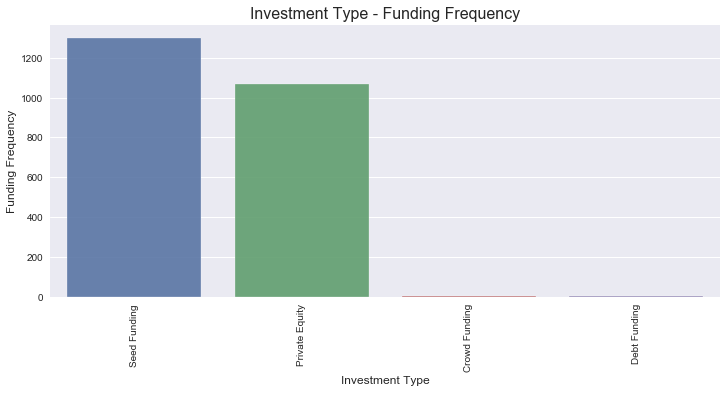

In [69]:
Investment_Type = fund['InvestmentType'].value_counts()
print(Investment_Type)
plt.figure(figsize=(12,5))
sns.barplot(Investment_Type.index, Investment_Type.values, alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Investment Type', fontsize=12)
plt.ylabel('Funding Frequency', fontsize=12)
plt.title("Investment Type - Funding Frequency", fontsize=16)
plt.show()

Undisclosed Investors                99
Ratan Tata                           24
Indian Angel Network                 24
Kalaari Capital                      16
Group of Angel Investors             15
Sequoia Capital                      14
Brand Capital                        10
RoundGlass Partners                  10
Accel Partners                        9
SAIF Partners                         9
Info Edge (India) Ltd                 8
Nexus Venture Partners                7
Unitus Seed Fund                      7
YouWeCan Ventures                     7
Tiger Global                          7
Blume Ventures                        6
Trifecta Capital                      6
The Chennai Angels                    5
India Educational Investment Fund     5
India Quotient                        5
Name: InvestorsName, dtype: int64


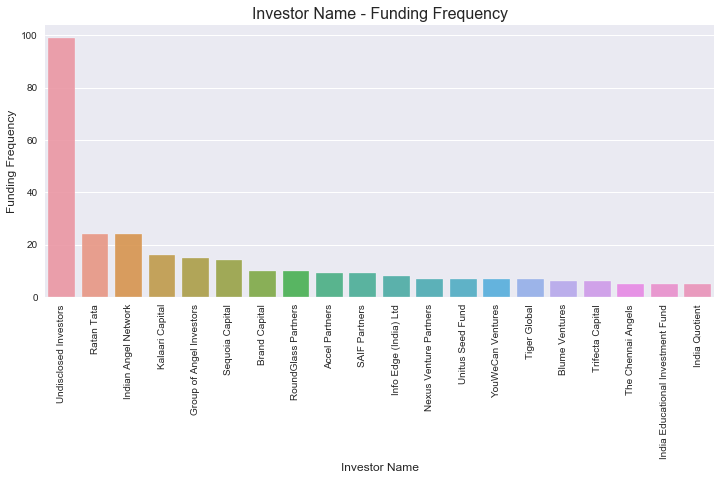

In [70]:
Investor_name = fund['InvestorsName'].value_counts().head(20)
print(Investor_name)
plt.figure(figsize=(12,5))
sns.barplot(Investor_name.index, Investor_name.values, alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Investor Name', fontsize=12)
plt.ylabel('Funding Frequency', fontsize=12)
plt.title("Investor Name - Funding Frequency", fontsize=16)
plt.show()

Important Investors in Indian Startup Scene - Ratan Tata, Indian Angel Network, Kalaari Capital, Sequoia Capital


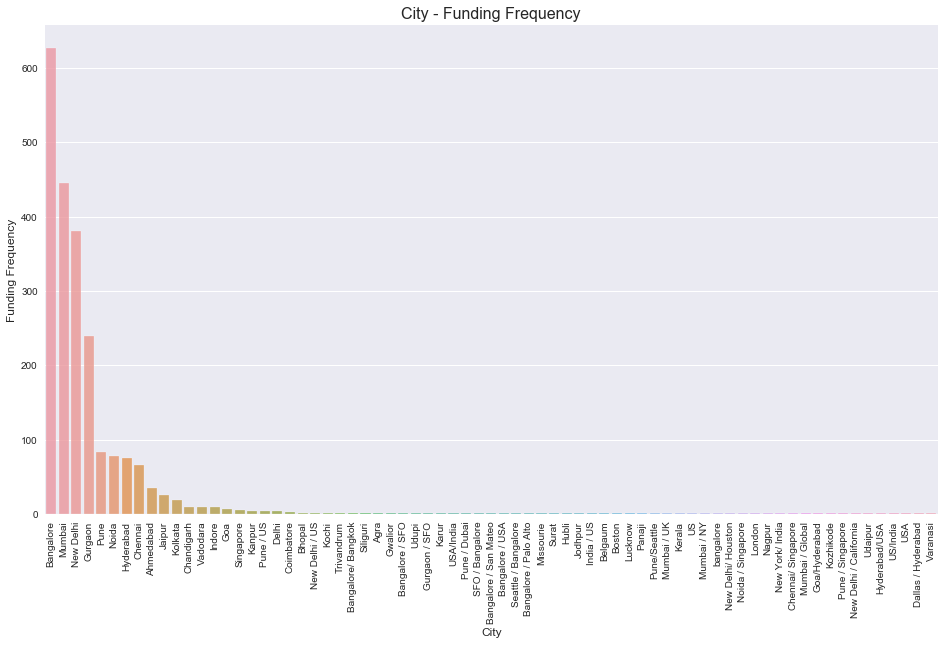

In [71]:
fund = fund['CityLocation'].value_counts()
plt.figure(figsize=(16,9))
sns.barplot(fund.index, fund.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('City', fontsize=12)
plt.ylabel('Funding Frequency', fontsize=12)
plt.title('City - Funding Frequency', fontsize=16)
plt.show()

Investors Count
Banglore 627 (26.4%)
Mumbai 446 (18.8%)
New Delhi 381 (16.1%)
Tier II, III cities: Varanasi, Indore, Siliguri, Karur, Nagpur, Belgaum, Kozhikode

# Keep Month and Year out of Date Column

In [72]:
fund_withAmts['MonthYear'] = fund_withAmts['Date'].map(lambda x: x.strftime('%Y-%m'))

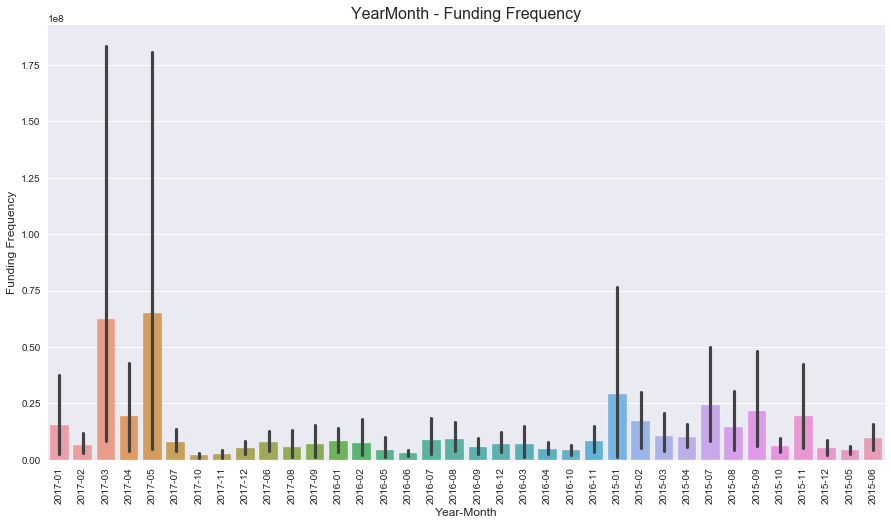

In [73]:
plt.figure(figsize=(15,8))
sns.barplot(fund_withAmts['MonthYear'], fund_withAmts['AmountInUSD'], alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Funding Frequency', fontsize=12)
plt.title("YearMonth - Funding Frequency", fontsize=16)
plt.show()

March '17 and May '17 - Flipkart and Paytm had received funding

# Drop Columns which are not relevant

In [74]:
fund_withAmts.drop(columns = ['Date', 'SNo', 'Remarks'], inplace=True, axis=1)

In [75]:
fund_withAmts.head()

,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Final Remarks,MonthYear
0,TouchKin,Technology,Predictive Care Platform,Bangalore,Kae Capital,Private Equity,1300000.0,NaN,2017-01
3,Zepo,Consumer Internet,DIY Ecommerce platform,Mumbai,"Kunal Shah, LetsVenture, Anupam Mittal, Hetal ...",Seed Funding,500000.0,NaN,2017-02
4,Click2Clinic,Consumer Internet,healthcare service aggregator,Hyderabad,"Narottam Thudi, Shireesh Palle",Seed Funding,850000.0,NaN,2017-02
5,Billion Loans,Consumer Internet,Peer to Peer Lending platform,Bangalore,Reliance Corporate Advisory Services Ltd,Seed Funding,1000000.0,NaN,2017-01
6,Ecolibriumenergy,Technology,Energy management solutions provider,Ahmedabad,"Infuse Ventures, JLL",Private Equity,2600000.0,NaN,2017-03


# Further EDA

In [76]:
fund_withAmts.shape
fund_withAmts['AmountInUSD'].value_counts()

1000000.0      122
500000.0        86
2000000.0       52
100000.0        52
3000000.0       45
5000000.0       44
10000000.0      41
150000.0        39
200000.0        36
15000000.0      32
250000.0        31
6000000.0       28
300000.0        27
4000000.0       27
1500000.0       24
600000.0        21
400000.0        18
1200000.0       17
20000000.0      14
350000.0        14
450000.0        14
2500000.0       14
25000000.0      13
30000000.0      13
50000000.0      12
750000.0        10
100000000.0     10
3500000.0        9
650000.0         9
12000000.0       8
              ... 
466000.0         1
9500000.0        1
12750000.0       1
6300000.0        1
223608.0         1
395000.0         1
441000.0         1
700000000.0      1
7400000.0        1
89000.0          1
63000000.0       1
104500000.0      1
970000.0         1
443000.0         1
108000.0         1
8900000.0        1
400000000.0      1
31300000.0       1
25000.0          1
52000.0          1
16600000.0       1
376000.0    

# Investments

Mean Investment from 2015-2017 $ 12284549
Median Investment from 2015-2017 $ 1000000
Maximum Single Investment from 2015-2017 $ 1400000000
Minimum Single Investment from 2015-2017 $ 18000


Text(0.5, 1.0, 'Funding vs Month-Year')

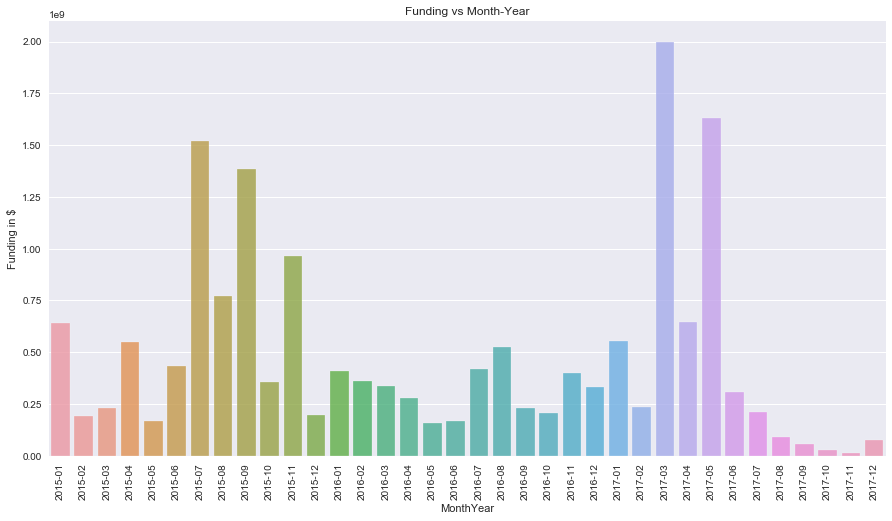

In [77]:
print('Mean Investment from 2015-2017 $ {:.0f}'.format(np.mean(fund_withAmts['AmountInUSD'])))
print('Median Investment from 2015-2017 $ {:.0f}'.format(np.median(fund_withAmts['AmountInUSD'])))
print('Maximum Single Investment from 2015-2017 $ {:.0f}'.format(np.max(fund_withAmts['AmountInUSD'])))
print('Minimum Single Investment from 2015-2017 $ {:.0f}'.format(np.min(fund_withAmts['AmountInUSD'])))
funding_permonth=fund_withAmts['AmountInUSD'].groupby(fund_withAmts['MonthYear']).sum()
plt.figure(figsize=(15,8))
sns.barplot(x=funding_permonth.index, y=funding_permonth.values, alpha=0.8)
plt.xticks(rotation=90)
plt.ylabel('Funding in $')
plt.title('Funding vs Month-Year')

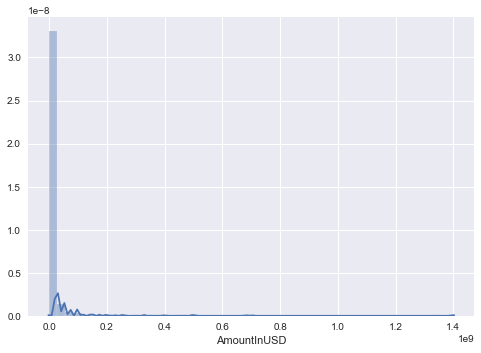

In [78]:
# Histograms
sns.distplot(fund_withAmts['AmountInUSD'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


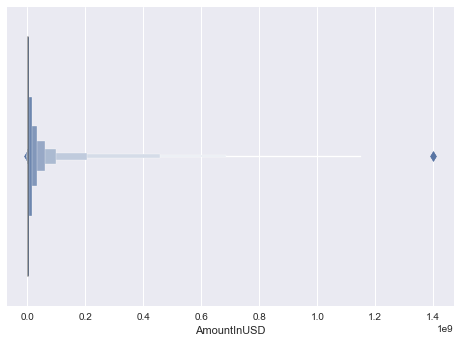

In [79]:
sns.set_style("darkgrid")
sns.boxenplot(fund_withAmts['AmountInUSD'])

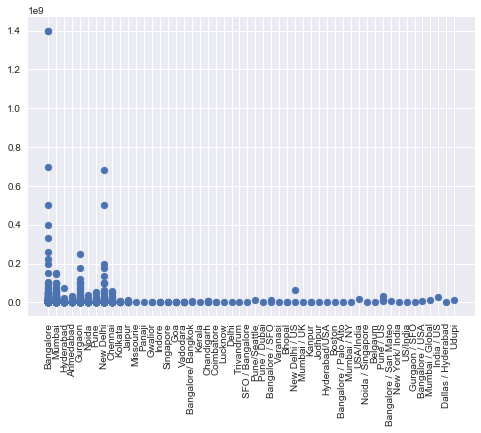

(1390, 9)

In [80]:
plt.scatter(fund_withAmts['CityLocation'], fund_withAmts['AmountInUSD'])
plt.xticks(rotation=90)
plt.show()
fund_withAmts.shape

In [81]:
fund_withAmts['AmountInUSD'].median()

1000000.0

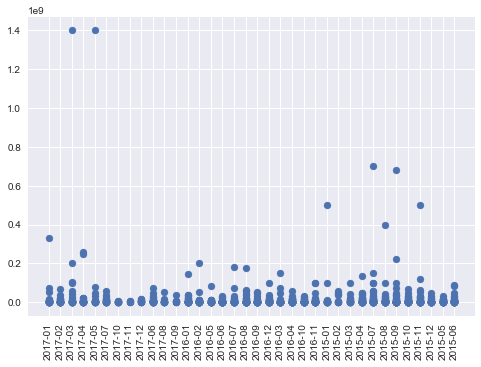

In [82]:
plt.scatter(fund_withAmts['MonthYear'], fund_withAmts['AmountInUSD'])
plt.xticks(rotation=90)
plt.show()

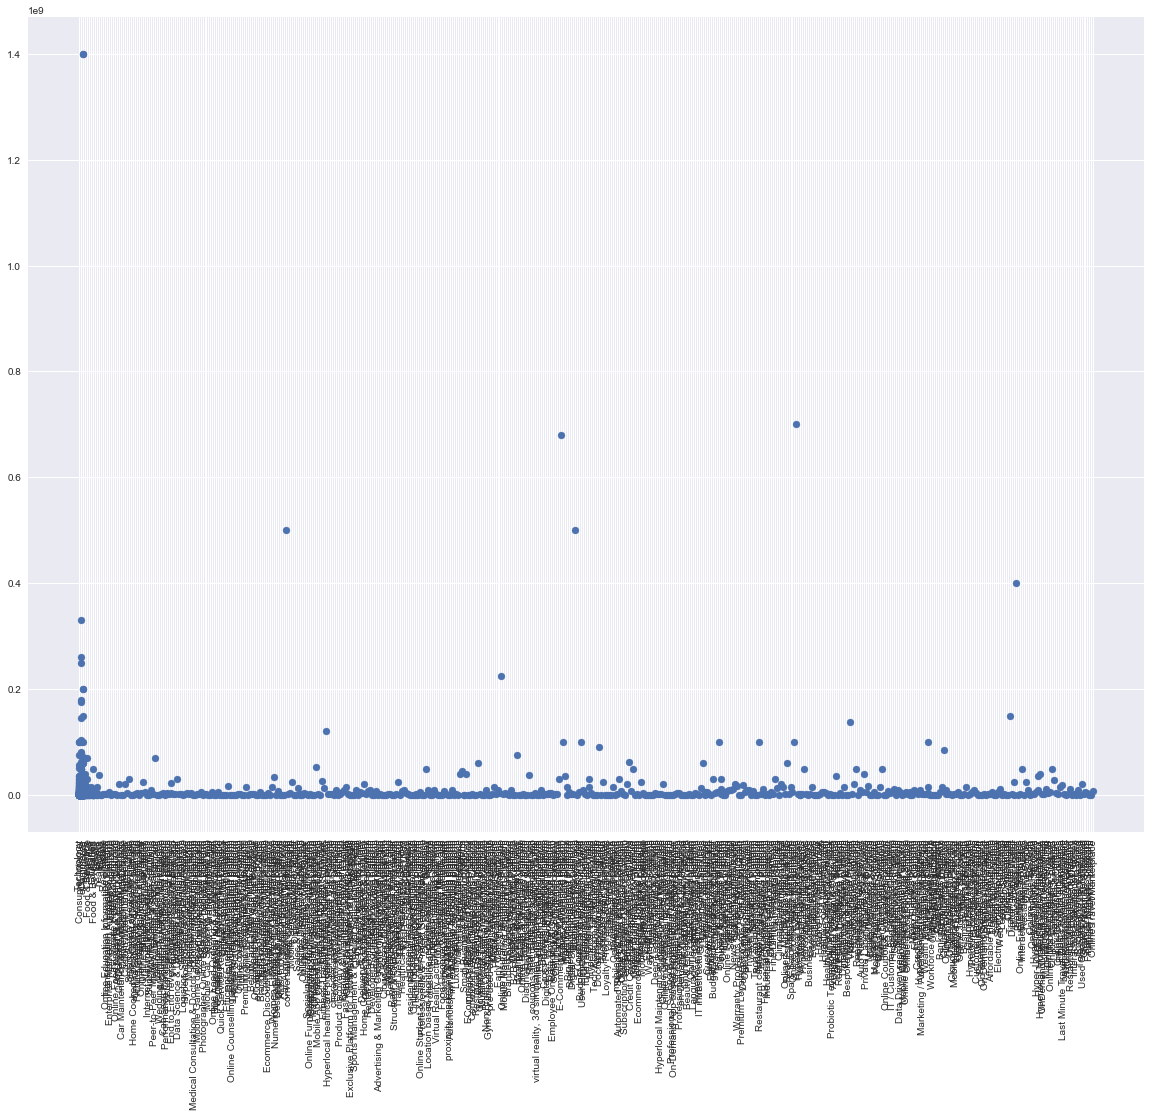

In [83]:
plt.figure(figsize=(20,15))
plt.scatter(fund_withAmts['IndustryVertical'], fund_withAmts['AmountInUSD'])
plt.xticks(rotation=90)
plt.show()

<Figure size 1440x864 with 0 Axes>

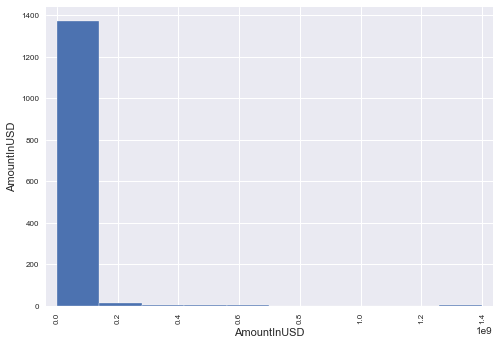

In [84]:
plt.figure(figsize=(20,12))
scatter_matrix(fund_withAmts)
plt.show()

# Drop Outliers

In [31]:
fund_withAmts = fund_withAmts.sort_values(by=['AmountInUSD'], ascending=False)

In [32]:
round(2/100*fund_withAmts.shape[0]) #drop 2% outliers

28

In [85]:
fund_withAmts.describe()
fund_withAmts.shape

(1390, 9)

In [143]:
fund_withAmtsOLrem = fund_withAmts.iloc[round(2/100*fund_withAmts.shape[0]):,:] #drop 2% upper outliers

In [144]:
fund_withAmtsOLrem.describe()

,AmountInUSD
count,1.362000e+03
mean,1.241202e+07
std,6.747456e+07
min,1.800000e+04
25%,3.775000e+05
50%,1.000000e+06
75%,5.800000e+06
max,1.400000e+09


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


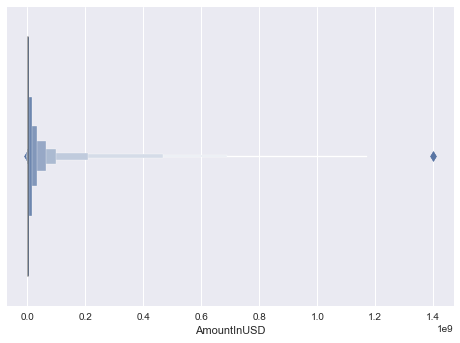

In [145]:
sns.boxenplot(fund_withAmtsOLrem['AmountInUSD'])

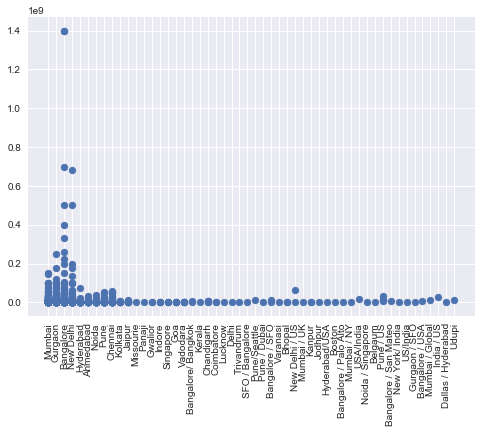

In [146]:
plt.scatter(fund_withAmtsOLrem['CityLocation'], fund_withAmtsOLrem['AmountInUSD'])
plt.xticks(rotation=90)
plt.show()

# Models 

In [169]:
fund_withAmtsOLrem.head()

,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Final Remarks,MonthYear
50,Goomo,Consumer Internet,Online Travel & Holiday Booking platform,Mumbai,Emerging India,Private Equity,50000000.0,NaN,2017-05
52,Spinny,eCommerce,Online Used Car marketplace,Gurgaon,"Blume Ventures, Indian Angel Network, Kunal Sh...",Private Equity,1000000.0,NaN,2017-06
55,BHIVE Workspace,Consumer Internet,co-working spaces,Bangalore,Blume Ventures,Private Equity,1200000.0,NaN,2017-06
56,wayForward,Consumer Internet,Mobile app for Mental Health,New Delhi,"Harsh Mahajan, Farhan Naqvi, Sreepathy Viswana...",Seed Funding,1000000.0,NaN,2017-06
59,ZipLoan,Consumer Internet,Online lending platform,New Delhi,WaterBridge Ventures,Seed Funding,650000.0,NaN,2017-07


# One Hot Encoding

In [212]:
# predictor columns=['StartupName','IndustryVertical','SubVertical','CityLocation','InvestorsName','InvestmentType', 'Final Remarks','MonthYear'])
fund_LR = fund_withAmtsOLrem.copy()
col_predictor = ['StartupName','InvestmentType','Final Remarks','IndustryVertical','InvestorsName','CityLocation','MonthYear']
drop_columns = ['AmountInUSD', 'SubVertical']
X = pd.get_dummies(data=fund_LR, columns = col_predictor, drop_first=True)
X = X.drop(columns = drop_columns)
y = fund_LR['AmountInUSD']
X.head()

,StartupName_1mg (Healthkartplus),StartupName_33Coupons,StartupName_360Ride,StartupName_3Dexter,StartupName_48East,StartupName_4tigo,StartupName_6Degree,StartupName_99PerHour,StartupName_ABI Health,StartupName_Aahaa,...,MonthYear_2017-03,MonthYear_2017-04,MonthYear_2017-05,MonthYear_2017-06,MonthYear_2017-07,MonthYear_2017-08,MonthYear_2017-09,MonthYear_2017-10,MonthYear_2017-11,MonthYear_2017-12
50,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
55,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


# Linear Regression

In [220]:
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=100, train_size=0.7, test_size=0.3)

In [221]:
lr = LinearRegression()
def calc_mse_linear_reg(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred1 = model.predict(X_train)
    print("RMSE-train {:.3f}".format((mean_squared_error(y_train, y_pred1))**0.5))
    print("RMSE-test {:.3f}".format((mean_squared_error(y_test, y_pred))**0.5))
    print("Accuracy Train: {:.3f} Test: {:.3f}".format(model.score(X_train,y_train),model.score(X_test,y_test)))
    return (mean_squared_error(y_train, y_pred1))**0.5, (mean_squared_error(y_test, y_pred))**0.5

In [222]:
calc_mse_linear_reg(lr,X_train, X_test, y_train, y_test)

RMSE-train 0.000
RMSE-test 41610847.635
Accuracy Train: 1.000 Test: 0.319


(1.2767565172087597e-06, 41610847.6346451)

In [223]:
p=16000
steps=[('model', Lasso(alpha=p))]
lasso_pipe=Pipeline(steps)
lasso_pipe.fit(X_train, y_train)
print('alpha {}'.format(p))
calc_mse_linear_reg(lasso_pipe,X_train, X_test, y_train, y_test)
print('\n')

alpha 16000
RMSE-train 5541098.825
RMSE-test 44053360.623
Accuracy Train: 0.994 Test: 0.237




In [254]:
p=0.8
steps=[('model', Ridge(alpha=p))]
ridge_pipe=Pipeline(steps)
ridge_pipe.fit(X_train, y_train)
print('alpha {}'.format(p))
calc_mse_linear_reg(ridge_pipe,X_train, X_test, y_train, y_test)
print('\n')

alpha 0.8
RMSE-train 24397428.515
RMSE-test 39515354.864
Accuracy Train: 0.890 Test: 0.386




In [264]:
ridge_pipe.named_steps['model']

Ridge(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

# Decision Tree Regression

In [313]:
fund_DT = fund_withAmtsOLrem.copy()
#missing data observing in columns
total = fund_withAmtsOLrem.isnull().sum(axis=0).sort_values(ascending=False)
percent = ((fund_withAmtsOLrem.isnull().sum(axis=0)/fund_withAmtsOLrem.isnull().count(axis=0))*100).sort_values(ascending=False)

# count the number of null values in the column and their perecentage of the total data
missing_data_columns = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data_columns

,Total,Percent
Final Remarks,1216,89.280470
SubVertical,521,38.252570
InvestorsName,5,0.367107
MonthYear,0,0.000000
AmountInUSD,0,0.000000
InvestmentType,0,0.000000
CityLocation,0,0.000000
IndustryVertical,0,0.000000
StartupName,0,0.000000


In [314]:
fund_DT=fund_DT.fillna('')
fund_DT.head()

,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Final Remarks,MonthYear
50,Goomo,Consumer Internet,Online Travel & Holiday Booking platform,Mumbai,Emerging India,Private Equity,50000000.0,,2017-05
52,Spinny,eCommerce,Online Used Car marketplace,Gurgaon,"Blume Ventures, Indian Angel Network, Kunal Sh...",Private Equity,1000000.0,,2017-06
55,BHIVE Workspace,Consumer Internet,co-working spaces,Bangalore,Blume Ventures,Private Equity,1200000.0,,2017-06
56,wayForward,Consumer Internet,Mobile app for Mental Health,New Delhi,"Harsh Mahajan, Farhan Naqvi, Sreepathy Viswana...",Seed Funding,1000000.0,,2017-06
59,ZipLoan,Consumer Internet,Online lending platform,New Delhi,WaterBridge Ventures,Seed Funding,650000.0,,2017-07


In [315]:
cat_var = ['IndustryVertical','CityLocation','InvestorsName','InvestmentType', 'MonthYear']
left_var = []
le = LabelEncoder()
for column in cat_var:
    fund_DT.loc[:,column] = le.fit_transform(fund_DT.loc[:,column])
fund_DT.head()

,StartupName,IndustryVertical,SubVertical,CityLocation,InvestorsName,InvestmentType,AmountInUSD,Final Remarks,MonthYear
50,Goomo,63,Online Travel & Holiday Booking platform,30,261,1,50000000.0,,28
52,Spinny,492,Online Used Car marketplace,16,169,1,1000000.0,,29
55,BHIVE Workspace,63,co-working spaces,1,164,1,1200000.0,,29
56,wayForward,63,Mobile app for Mental Health,34,353,2,1000000.0,,29
59,ZipLoan,63,Online lending platform,34,1062,2,650000.0,,30


In [352]:
col_DT = ['IndustryVertical','CityLocation','InvestmentType', 'MonthYear']
X = fund_DT.loc[:,col_DT]
y = fund_DT['AmountInUSD']

In [353]:
n = 9
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=n, train_size=0.75, test_size=0.25)
model = DecisionTreeRegressor(random_state=n)

In [362]:
params = {'criterion': ['mae', 'mse'], 'max_depth':[1,2,3,4,5,6,7,8,9,10], 'max_features':['sqrt','log2'], 'min_weight_fraction_leaf':[0.002, 0.0025]}
grid_search = GridSearchCV(estimator = model, param_grid = params)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(cross_val_score(grid_search.best_estimator_, X_train, y_train))
print('Test Score {:.3f}'.format(r2_score(y_test, y_pred)))
print('Test Error {:.3f}'.format(mean_squared_error(y_test, y_pred)**0.5))
print('Train Score {:.3f}'.format(r2_score(y_train, grid_search.predict(X_train))))
print('Train Error {:.3f}'.format(mean_squared_error(y_train, grid_search.predict(X_train))**0.5))
grid_search.best_estimator_

[ 0.0566987   0.21660697 -0.05709102]
Test Score 0.186
Test Error 49421051.702
Train Score 0.396
Train Error 55297893.802


DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0025,
           presort=False, random_state=9, splitter='best')

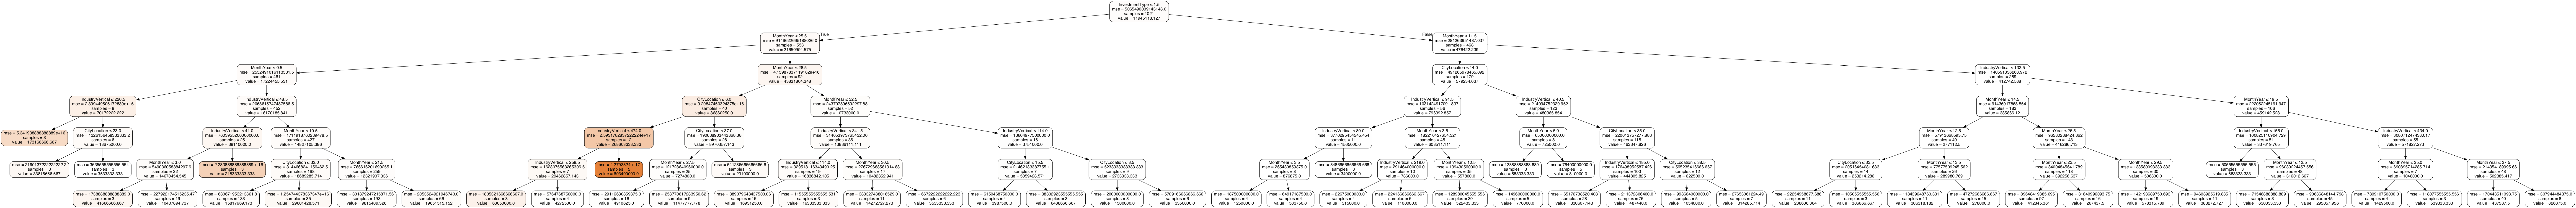

In [364]:
dt_tree=DecisionTreeRegressor(criterion='mse', max_depth=6, max_features='sqrt',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0025,
           presort=False, random_state=9, splitter='best')
dt_tree.fit(X_train, y_train)
X = 'IndustryVertical','CityLocation','InvestmentType', 'MonthYear'
y = 'AmountInUSD'
dot_data = tree.export_graphviz(dt_tree, out_file=None,
                               feature_names=X,
                               class_names=y,
                               filled=True, rounded=True,
                               special_characters=True)
graph=pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

# Random Forest

In [367]:
rfr = RandomForestRegressor(random_state=9)
parameter = {'n_estimators': [2,5,10,20,50], 
              'max_features': ['log2', 'sqrt'], 
              'criterion': ['mse', 'mae'],
              'max_depth': [1,2,4,6,8,10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,3,5]
             }
#task find the results for the given params
grid_rf = GridSearchCV(estimator = rfr, param_grid = parameter)
grid_rf.fit(X_train, y_train)
grid_rf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=9, verbose=0, warm_start=False)

In [344]:
y_pred_rfr = grid.predict(X_test)
print('Train Score {}'.format(r2_score(y_train,  grid.predict(X_train))))
print('Test Score {}'.format(r2_score(y_test, y_pred_rfr)))
grid.best_estimator_

Train Score 0.4929258611919868
Test Score -0.08244903598179754


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=9, verbose=0, warm_start=False)

In [345]:
xgbr = XGBRegressor(random_state=9)
xgbr.fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
r2_score(y_test, y_pred_xgbr)

-0.0851181268716712

In [366]:
mean_squared_error(y_test, y_pred_xgbr)**0.5

57073253.10259047